In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
pip install pycm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.8/599.8 kB 12.0 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


tf version: 2.12.0


/tmp/ipykernel_28/2197181697.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X)


Counter({0: 732, 1: 720})
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 dense_2 (Dense)             (None, 256)               262400    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 7,300,418
Trainable params: 7,216,770
Non-trainable params: 83,648
_________________________________________________________________
Epoch 1/50
19/19 [==============================] - ETA: 0s - loss: 0.6350 - accuracy: 0.8996
Epoch 1: val_loss improved from inf to 9.16038, sav

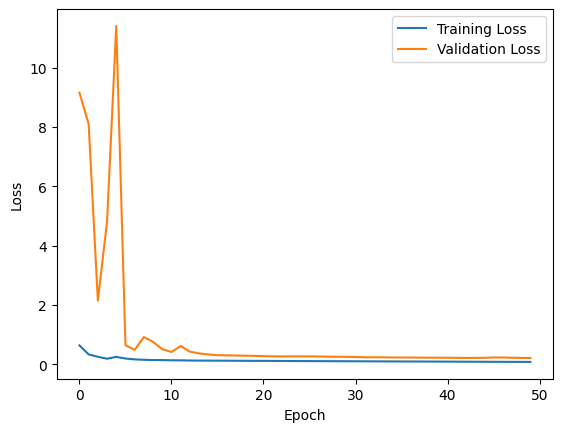

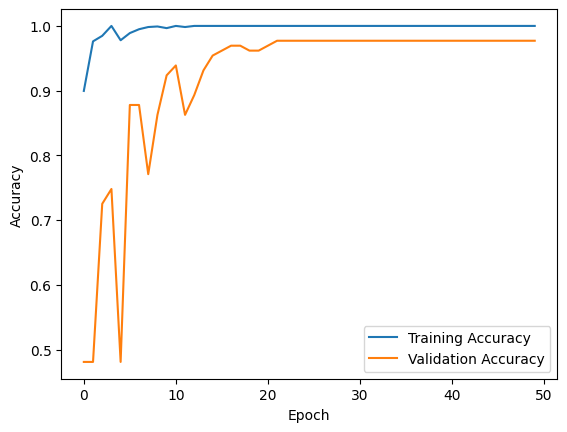

Test loss : 0.1187, Test Accuracy: 0.9932


Accuracy: 0.9932
Precision: 0.9865
Recall: 1.0000
F1 score: 0.9932
Cohens kappa: 0.9863
ROC AUC: 0.9932




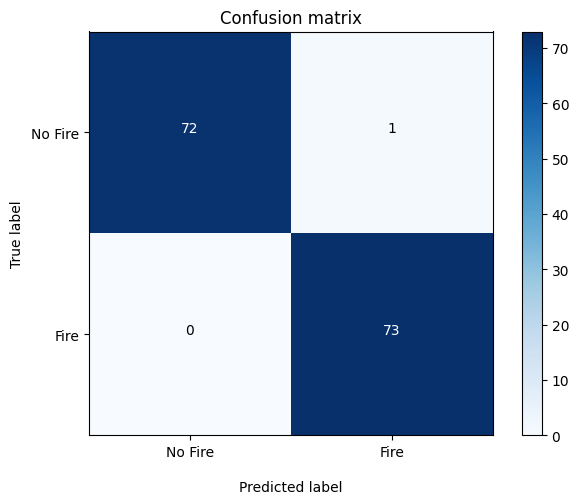





Report : 
              precision    recall  f1-score   support

     No Fire       1.00      0.99      0.99        73
        Fire       0.99      1.00      0.99        73

    accuracy                           0.99       146
   macro avg       0.99      0.99      0.99       146
weighted avg       0.99      0.99      0.99       146



MSE: 0.0068
RMSE: 0.0828




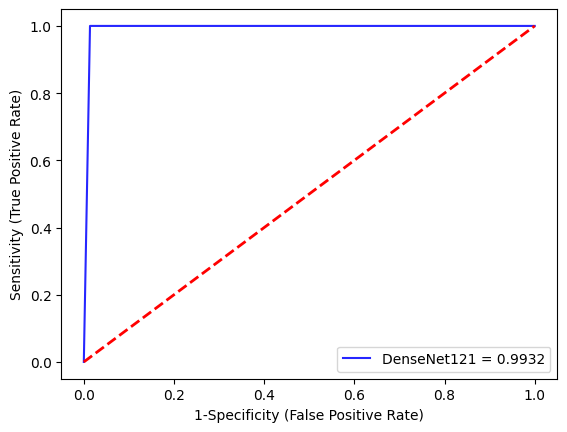



****************************** overall statistics start ******************************
Predict  0        1        
Actual
0        72       1        

1        0        73       





Overall Statistics : 

95% CI                                                            (0.97977,1.00653)
ACC Macro                                                         0.99315
ARI                                                               0.9726
AUNP                                                              0.99315
AUNU                                                              0.99315
Bangdiwala B                                                      0.9864
Bennett S                                                         0.9863
CBA                                                               0.98639
CSI                                                               0.98639
Chi-Squared                                                       142.05405
Chi-Squared DF                            

In [5]:
# -*- coding: utf-8 -*-
"""
Classification with DenseNet121 architecture and transfer learning method

@author: Hatice Catal Reis & Veysel Turk
"""

from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense
from pycm import ConfusionMatrix
from collections import Counter
from os import listdir
from math import sqrt

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import itertools
import os, shutil
import cv2

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,2,3,4"
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.99)
tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

print("tf version:", tf.__version__)

def load_data(dir_list, image_size):
    X = []
    y = []
    all_image_with_label = []
    image_width, image_height = image_size
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory + "/" + filename)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            image = image / 255.
            image_label_set_label = (0, 1)[directory[-4:] == 'fire']
            image_name_with_label = filename, image_label_set_label
            all_image_with_label.append(image_name_with_label)
            np.savetxt("results/densenet121_image_data_feature_save.csv", all_image_with_label, delimiter=",", fmt='%s')
            image_name_matrix_with_label = image, filename, image_label_set_label
            X.append(image_name_matrix_with_label)
            y.append((0, 1)[directory[-4:] == 'fire'])

    X = np.array(X)
    y = np.array(y)
    
    print(Counter(y))
    
    return X, y

def image_split_folder(source, destination_fire, destination_no_blaze, all_data):
    shutil.rmtree(destination_fire, ignore_errors=True)
    shutil.rmtree(destination_no_blaze, ignore_errors=True)
    os.makedirs(destination_fire)
    os.makedirs(destination_no_blaze)
    for directory_split_folder_name in source:
        files_create = os.listdir(directory_split_folder_name)
        for target, label in all_data:
            for f_crt in files_create:
                if target == f_crt:
                    if label == 1:
                        shutil.copy(directory_split_folder_name + f_crt, destination_fire + f_crt)
                    elif label == 0:
                        shutil.copy(directory_split_folder_name + f_crt, destination_no_blaze + f_crt)

def pred_fire_image_split_carry(X_test_name, pred_class, predictions):
    pred_target_with_label_01 = np.vstack((X_test_name[:, 1], pred_class)).T
    pred_target_with_label_possibility = np.vstack((X_test_name[:, 1], predictions)).T
    image_split_folder(["/kaggle/input/dataset/wildfires/fire/", "/kaggle/input/dataset/wildfires/no_blaze/"], "results/pred/fire/", "results/pred/no_blaze/", pred_target_with_label_01)
    np.savetxt("results/pred/densenet121_imagenet_fire_or_no_01.csv", pred_target_with_label_01, delimiter=",", fmt='%s')
    np.savetxt("results/pred/densenet121_imagenet_fire_or_no_possibility.csv", pred_target_with_label_possibility, delimiter=",", fmt='%s')

def image_to_4d(datas):
    list_to_4d_all_data = []
    for data_list_find in datas[:, 0]:
        list_to_4d_all_data.append(data_list_find)
    list_to_4d_all_data = np.array(list_to_4d_all_data)
    
    return list_to_4d_all_data

def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy'] 
    
    np.savetxt('results/densenet121_imagenet_training_loss.csv', train_loss, fmt="%1.16f", delimiter=",")
    np.savetxt('results/densenet121_imagenet_validation_loss.csv', val_loss, fmt="%1.16f", delimiter=",") 

    np.savetxt('results/densenet121_imagenet_training_accuracy.csv', train_acc, fmt="%1.16f", delimiter=",")
    np.savetxt('results/densenet121_imagenet_val_accuracy.csv', val_acc, fmt="%1.16f", delimiter=",") 
        
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc="best")
    plt.savefig('results/densenet121_imagenet_loss.jpg', dpi=600, bbox_inches='tight')
    plt.show()
    
    print("\n") 

    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc="best")
    plt.savefig('results/densenet121_imagenet_accuracy.jpg', dpi=600, bbox_inches='tight')
    plt.show()

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential



# def build_model(img_shape):
#     model = Sequential()
    
#     # Menambahkan base model DenseNet121
#     base_model = DenseNet121(input_shape=img_shape, include_top=False, weights='imagenet', pooling='max')
#     model.add(base_model)
    
#     # Menambahkan lapisan-lapisan tambahan dengan dropout
#     model.add(Dense(256, activation='relu'))
#     model.add(Dropout(0.5))  # Lapisan dropout
#     model.add(Dense(2, activation='softmax'))  # Output layer dengan 2 kelas
    
#     return model

from tensorflow.keras.layers import Dense, Dropout, Flatten

from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.regularizers import l2

# def build_model(img_shape, l2_lambda=0.001):
#     model = Sequential()
    
#     # Menambahkan base model DenseNet121
#     base_model = DenseNet121(input_shape=img_shape, include_top=False, weights='imagenet', pooling='max')
#     model.add(base_model)
    
#     # Menambahkan lapisan-lapisan tambahan dengan dropout dan regularisasi L2
#     model.add(Dense(256, activation='relu', kernel_regularizer=l2(l2_lambda)))
#     model.add(Dropout(0.5))  # Lapisan dropout
#     model.add(Dense(2, activation='softmax', kernel_regularizer=l2(l2_lambda)))  # Output layer dengan 2 kelas
    
#     return model


from tensorflow.keras.regularizers import l2

def build_model(img_shape, l2_lambda=0.001):
    model = Sequential()
    
    # Menambahkan base model DenseNet121
    base_model = DenseNet121(input_shape=img_shape, include_top=False, weights='imagenet', pooling='avg')  # Menggunakan pooling rata-rata ('avg')
    model.add(base_model)
    
    # Menambahkan lapisan-lapisan tambahan dengan dropout dan regularisasi L2
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(l2_lambda)))
    model.add(Dropout(0.5))  # Lapisan dropout
    model.add(Dense(2, activation='softmax', kernel_regularizer=l2(l2_lambda)))  # Output layer dengan 2 kelas
    
    return model


    
    
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label', labelpad=5)
    plt.xlabel('Predicted label', labelpad=15)
    plt.savefig("results/densenet121_imagenet_plt_cm.jpg", dpi=300, bbox_inches='tight')
    plt.show()

def statistc_analysis(actual, predict_classes_find):
    
    np.savetxt('results/densenet121_imagenet_pred.csv', predict_classes_find, fmt="%d", delimiter=",")
    np.savetxt('results/densenet121_imagenet_actual_test.csv', actual, fmt="%d", delimiter=",")    
    
    accuracy = accuracy_score(actual, predict_classes_find)
    print('Accuracy: %0.4f' % accuracy)
    
    precision = precision_score(actual, predict_classes_find)
    print('Precision: %0.4f' % precision)
    
    recall = recall_score(actual, predict_classes_find)
    print('Recall: %0.4f' % recall)
    
    f1 = f1_score(actual, predict_classes_find)
    print('F1 score: %0.4f' % f1)
    
    kappa = cohen_kappa_score(actual, predict_classes_find)
    print('Cohens kappa: %0.4f' % kappa)
    
    roc_auc_threshold = roc_auc_score(actual, predict_classes_find)
    print('ROC AUC: %0.4f' % roc_auc_threshold)
    print("\n")
    
    plt.figure()
    cnf_matrix = confusion_matrix(actual, predict_classes_find, labels=[0,1])
    plot_confusion_matrix(cnf_matrix, classes=['No Fire', 'Fire'], normalize=False, title='Confusion matrix')
    print("\n")
        
    print("\n")
    print ('Report : ')
    target_names = ['No Fire', 'Fire']
    print (classification_report(actual, predict_classes_find, target_names=target_names, digits=2))
    print("\n")
    
    mse = mean_squared_error(actual, predict_classes_find)
    print('MSE: %0.4f' % mse)
    
    rmse = sqrt(mse)
    print('RMSE: %0.4f' % rmse)
    print("\n")    
           
    fpr, tpr, thresholds = roc_curve(actual, predict_classes_find)
    roc_auc_threshold = 'DenseNet121 = %.4f' % (roc_auc_threshold)
    plt.plot(fpr, tpr,  color='#2626ff', label=roc_auc_threshold)
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='', linewidth=2)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.legend(loc="lower right")
    plt.xlabel('1-Specificity (False Positive Rate)')
    plt.ylabel('Sensitivity (True Positive Rate)')
    plt.savefig("results/densenet121_imagenet_roc_curve.jpg", dpi=300, bbox_inches='tight')
    plt.show()    
    print("\n") 
    
def overall_statistics(actual, predict_classes_find):
    
    cm = ConfusionMatrix(actual_vector=actual,predict_vector=predict_classes_find)
    
    print(cm)

def create_folder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error:' +  directory)

create_folder('results/')


X, y = load_data(["/kaggle/input/dataset/wildfires/no_blaze", "/kaggle/input/dataset/wildfires/fire"], (224,224))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

X_train_list_to_4d = image_to_4d(X_train)
X_test_list_to_4d = image_to_4d(X_test)

actual = y_test

y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

img_shape = (224, 224, 3)
model = build_model(img_shape)
model.summary()

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

filepath="results/densenet121_imagenet.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor="val_loss", verbose=1, save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001, verbose=0)
history = model.fit(X_train_list_to_4d, y_train, batch_size=64, epochs=50, validation_split=0.10, verbose=1, callbacks=[checkpoint, reduce_lr])
history=history.history
 
plot_metrics(history)

model = load_model('results/densenet121_imagenet.hdf5')

test_loss, test_acc = model.evaluate(X_test_list_to_4d, y_test, verbose=0)
print(f"Test loss : {test_loss:0.4}, Test Accuracy: {test_acc:0.4}")

print("\n")

predictions = model.predict(X_test_list_to_4d, verbose=0)
predict_classes_find=[]
predictions_end=[]
for prd_clssv in predictions:
    predictions_end.append(max(prd_clssv))
    predict_classes_find.append(prd_clssv.argmax())  
predict_classes_find=np.array(predict_classes_find)
predictions_end=np.array(predictions_end)

statistc_analysis(actual, predict_classes_find)

pred_fire_image_split_carry(X_test, predict_classes_find, predictions_end)

print("*"*30,"overall statistics start","*"*30)
overall_statistics(actual, predict_classes_find)
print("*"*30,"overall statistics end","*"*30)

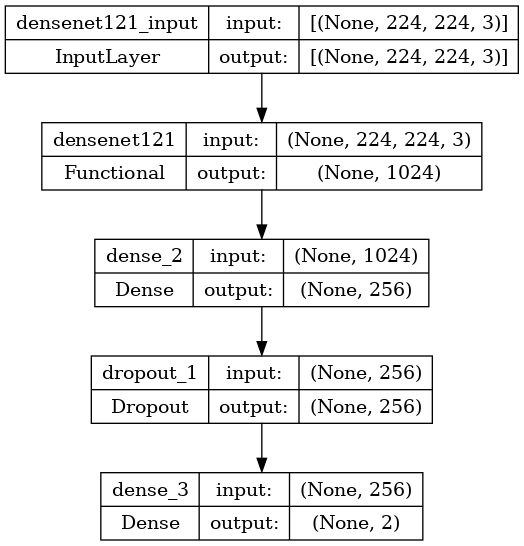

In [6]:
from tensorflow.keras.utils import plot_model

# model adalah objek model Anda
plot_model(model, to_file='results/model_project.png', show_shapes=True, show_layer_names=True)